In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Укажи путь к датасету
file_path = r'C:\ML_PROJECT\data\dataset.parquet'

# Загружаем данные
df = pd.read_parquet(file_path)

# Посмотрим первые строки
print("Первые 5 строк:")
print(df.head())

# Общая информация
print("\nРазмер датасета:", df.shape)
print("\nИнформация о колонках:")
print(df.info())

# Проверим наличие пропусков
print("\nКоличество пропусков в каждой колонке:")
print(df.isnull().sum())

# Проверим наличие дубликатов
print(f"\nКоличество дубликатов: {df.duplicated().sum()}")

# Целевая переменная
print("\nРаспределение целевой переменной (target):")
print(df['target'].value_counts())

Первые 5 строк:
   borrow_block_number  borrow_timestamp  \
0              7711117      1.557197e+09   
1              7711123      1.557197e+09   
2              7711126      1.557197e+09   
3              7711672      1.557205e+09   
4              7712572      1.557217e+09   

                               wallet_address  first_tx_timestamp  \
0  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
1  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
2  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
3  0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6        1.557191e+09   
4  0xbd9ed130a53cfafcf81502e4d35329a6c4d53410        1.557217e+09   

   last_tx_timestamp  wallet_age  incoming_tx_count  outgoing_tx_count  \
0       1.557197e+09  19973049.0                199                438   
1       1.557197e+09  19973188.0                200                439   
2       1.557197e+09  19973238.0                201                440   
3       

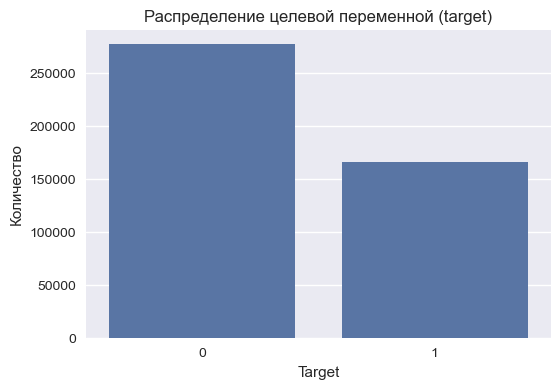

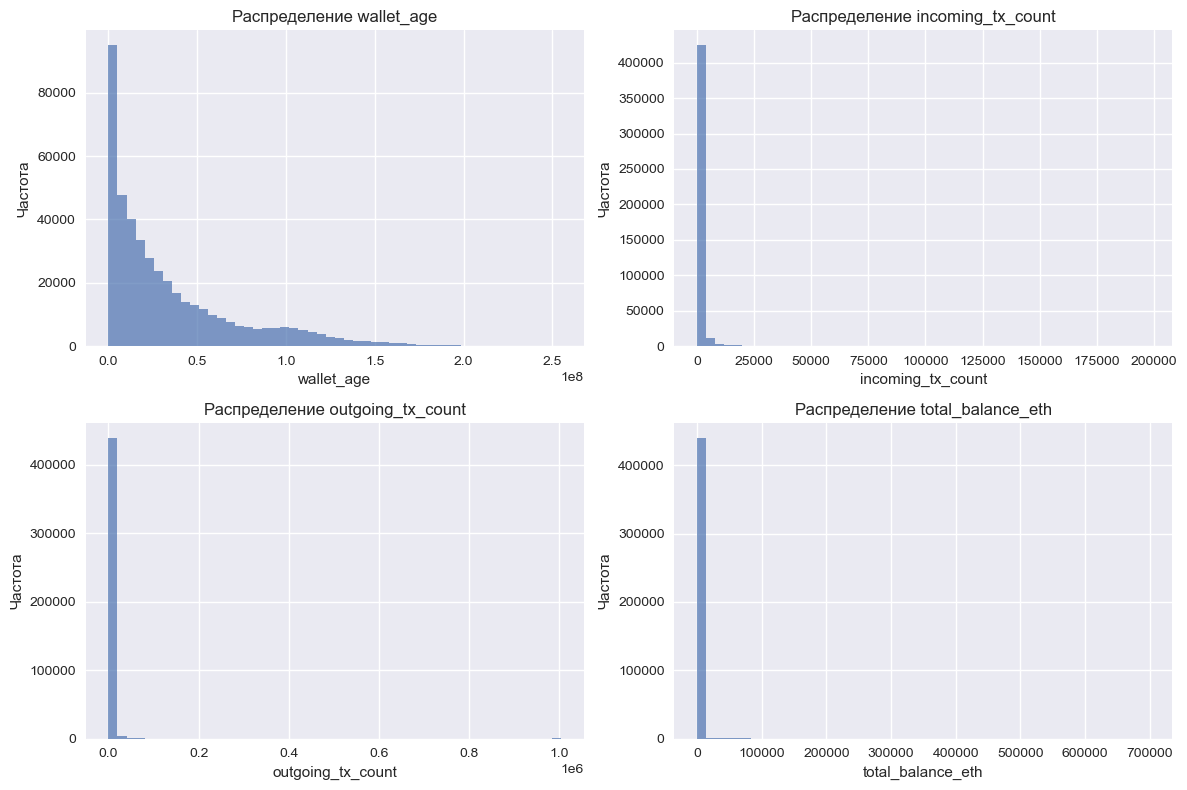

In [ ]:
# График распределения целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Распределение целевой переменной (target)')
plt.xlabel('Target')
plt.ylabel('Количество')
plt.savefig('target_distribution.png')
plt.show()

# Посмотрим на распределение нескольких числовых признаков
numeric_cols = ['wallet_age', 'incoming_tx_count', 'outgoing_tx_count', 'total_balance_eth']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 2, i + 1)
    plt.hist(df[col].dropna(), bins=50, alpha=0.7)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
plt.tight_layout()
plt.savefig('numeric_features_distribution.png')
plt.show()

In [2]:
# Импорты
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
file_path = r'C:\ML_PROJECT\data\dataset.parquet'
df = pd.read_parquet(file_path)

# Сделаем выборку, чтобы не перегружать систему
df_sample = df.sample(frac=0.1, random_state=42)

# Удалим колонки, которые не подходят для модели (например, адреса, временные метки)
drop_cols = ['wallet_address', 'borrow_timestamp', 'first_tx_timestamp', 
             'last_tx_timestamp', 'risky_first_tx_timestamp', 'risky_last_tx_timestamp']
X = df_sample.drop(columns=drop_cols + ['target'])
y = df_sample['target']

# Удалим строки с пропусками (или можно заполнить, если пропусков немного)
X = X.dropna()
y = y.loc[X.index]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование не обязательно для деревьев, но может помочь для логрегрессии
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Словарь для хранения результатов
results = {}

# 1. Логистическая регрессия
print("Обучение Logistic Regression...")
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_scaled, y_train)
pred_lr = model_lr.predict(X_test_scaled)
prob_lr = model_lr.predict_proba(X_test_scaled)[:, 1]
results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, pred_lr),
    'roc_auc': roc_auc_score(y_test, prob_lr)
}

# 2. Дерево решений
print("Обучение Decision Tree...")
model_dt = DecisionTreeClassifier(random_state=42, max_depth=10)
model_dt.fit(X_train, y_train)
pred_dt = model_dt.predict(X_test)
prob_dt = model_dt.predict_proba(X_test)[:, 1]
results['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, pred_dt),
    'roc_auc': roc_auc_score(y_test, prob_dt)
}

# 3. Random Forest
print("Обучение Random Forest...")
model_rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
prob_rf = model_rf.predict_proba(X_test)[:, 1]
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, pred_rf),
    'roc_auc': roc_auc_score(y_test, prob_rf)
}

# 4. XGBoost
print("Обучение XGBoost...")
model_xgb = xgb.XGBClassifier(n_estimators=50, random_state=42, n_jobs=-1)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
prob_xgb = model_xgb.predict_proba(X_test)[:, 1]
results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, pred_xgb),
    'roc_auc': roc_auc_score(y_test, prob_xgb)
}

# Выводим результаты
print("\nРезультаты моделей:")
for model, metrics in results.items():
    print(f"{model}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  ROC-AUC:  {metrics['roc_auc']:.4f}\n")

Обучение Logistic Regression...
Обучение Decision Tree...
Обучение Random Forest...
Обучение XGBoost...

Результаты моделей:
Logistic Regression:
  Accuracy: 0.7740
  ROC-AUC:  0.7888

Decision Tree:
  Accuracy: 0.7995
  ROC-AUC:  0.8309

Random Forest:
  Accuracy: 0.8362
  ROC-AUC:  0.9006

XGBoost:
  Accuracy: 0.8242
  ROC-AUC:  0.8896



Создаём SHAP explainer...
Вычисляем SHAP значения...
Строим SHAP summary plot...


<Figure size 1000x800 with 0 Axes>

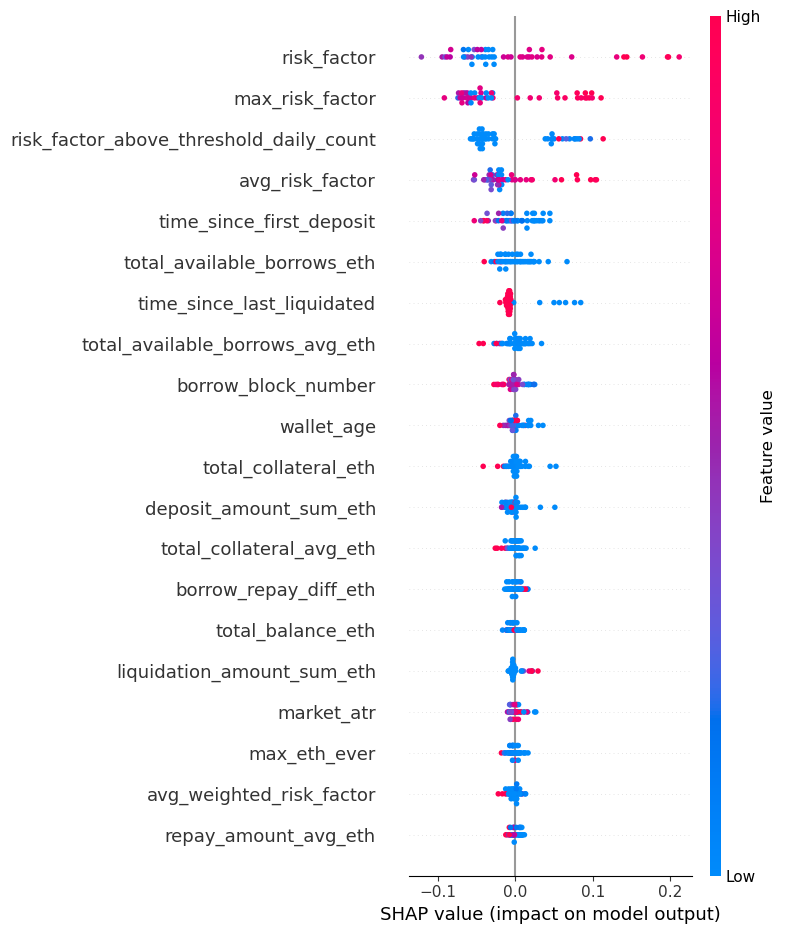

Строим SHAP force plot для объекта 0...


Force plot сохранён в force_plot_sample.html
Строим SHAP bar plot (среднее влияние признаков)...


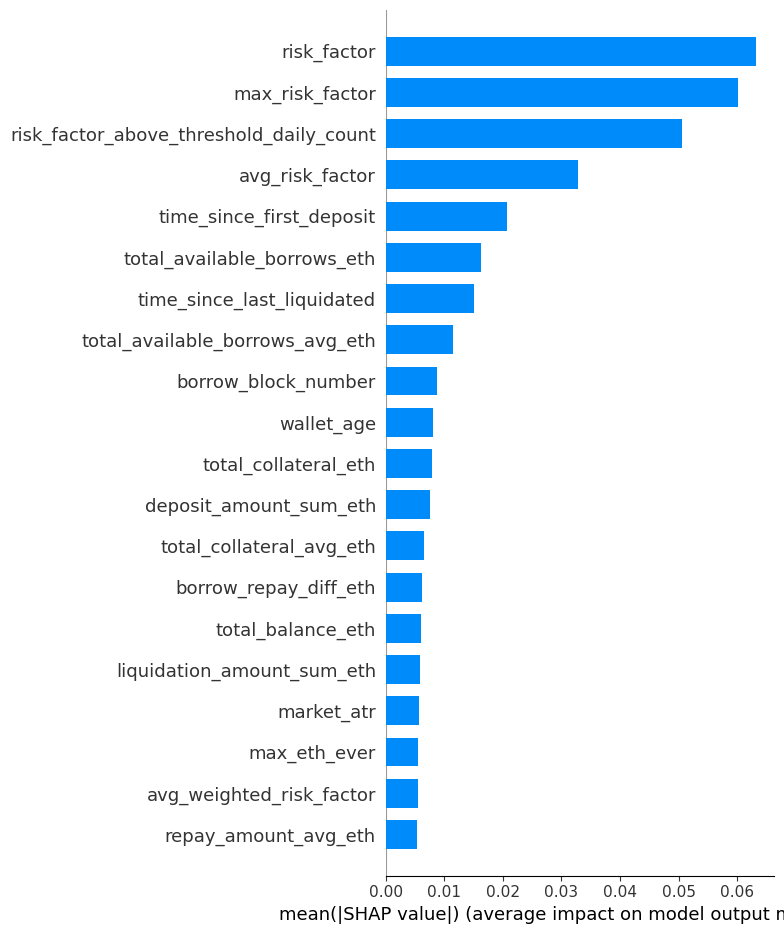

Графики SHAP сохранены в файлы:
 - shap_summary_plot.png
 - force_plot_sample.html (или .png)
 - shap_bar_plot.png


In [6]:
# Импорты
import shap
import matplotlib.pyplot as plt
import numpy as np

# Берём небольшую выборку из тестовых данных для SHAP (например, 50 записей)
X_test_sample = X_test.sample(n=50, random_state=42)

# Создаём explainer для Random Forest
print("Создаём SHAP explainer...")
explainer = shap.TreeExplainer(model_rf)

# Вычисляем SHAP значения
print("Вычисляем SHAP значения...")
shap_values = explainer.shap_values(X_test_sample)

# Обработка в зависимости от типа shap_values
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]  # Для класса 1
else:
    if len(shap_values.shape) == 3:
        shap_values_to_plot = shap_values[:, :, 1]  # Берём для класса 1
    else:
        shap_values_to_plot = shap_values

# Увеличиваем размер шрифта для всех графиков
plt.rcParams['font.size'] = 12

# Выводим сводку SHAP (summary plot) - улучшенная версия
print("Строим SHAP summary plot...")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_to_plot, X_test_sample, show=False)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=150, bbox_inches='tight')
plt.show()

# Строим force plot для одного примера
index = 0  # Можно выбрать любой индекс от 0 до 49
print(f"Строим SHAP force plot для объекта {index}...")
shap.initjs()  # Инициализация для интерактивных графиков

try:
    force_plot = shap.force_plot(
        explainer.expected_value[1],
        shap_values_to_plot[index],
        X_test_sample.iloc[index],
        matplotlib=False,  # Интерактивный HTML
        show=False
    )
    shap.save_html("force_plot_sample.html", force_plot)
    print("Force plot сохранён в force_plot_sample.html")
except Exception as e:
    print(f"Не удалось сохранить force plot: {e}")
    # Альтернатива - matplotlib версия force plot
    try:
        plt.figure(figsize=(12, 4))
        force_plot = shap.force_plot(
            explainer.expected_value[1],
            shap_values_to_plot[index],
            X_test_sample.iloc[index],
            matplotlib=True,
            show=False
        )
        plt.tight_layout()
        plt.savefig('force_plot_sample.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Force plot (matplotlib) сохранён в force_plot_sample.png")
    except Exception as e2:
        print(f"Не удалось построить force plot: {e2}")

# Попробуем bar plot - показывает среднее влияние признаков
print("Строим SHAP bar plot (среднее влияние признаков)...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_to_plot, X_test_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Графики SHAP сохранены в файлы:")
print(" - shap_summary_plot.png")
print(" - force_plot_sample.html (или .png)")
print(" - shap_bar_plot.png")

In [7]:
import joblib
import os

# Создаём папку для модели, если её нет
model_dir = r'C:\ML_PROJECT\models'
os.makedirs(model_dir, exist_ok=True)

# Сохраняем лучшую модель (Random Forest)
model_path = os.path.join(model_dir, 'random_forest_model.pkl')
joblib.dump(model_rf, model_path)
print(f"Модель сохранена в: {model_path}")

# Также сохраним scaler (если он нужен для логрегрессии, но мы его тоже сохраним на всякий случай)
scaler_path = os.path.join(model_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler сохранён в: {scaler_path}")

# Сохраняем список признаков (чтобы знать, какие колонки использовать при предсказании)
import pandas as pd
feature_names = list(X.columns)
features_path = os.path.join(model_dir, 'feature_names.pkl')
joblib.dump(feature_names, features_path)
print(f"Названия признаков сохранены в: {features_path}")

Модель сохранена в: C:\ML_PROJECT\models\random_forest_model.pkl
Scaler сохранён в: C:\ML_PROJECT\models\scaler.pkl
Названия признаков сохранены в: C:\ML_PROJECT\models\feature_names.pkl


In [8]:
# model_inference.py
import pandas as pd
import joblib
import os
import numpy as np

class ModelInference:
    def __init__(self, model_path, scaler_path, features_path):
        """Инициализация модели и вспомогательных объектов"""
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.feature_names = joblib.load(features_path)
        
    def preprocess_data(self, df):
        """Предобработка входных данных"""
        # Удаляем ненужные колонки (если они есть)
        drop_cols = ['wallet_address', 'borrow_timestamp', 'first_tx_timestamp', 
                    'last_tx_timestamp', 'risky_first_tx_timestamp', 'risky_last_tx_timestamp']
        
        # Оставляем только нужные признаки
        df_processed = df.copy()
        for col in drop_cols:
            if col in df_processed.columns:
                df_processed = df_processed.drop(columns=[col])
        
        # Оставляем только те признаки, которые были при обучении
        missing_cols = set(self.feature_names) - set(df_processed.columns)
        for col in missing_cols:
            df_processed[col] = 0  # Добавляем недостающие колонки с нулями
            
        # Упорядочиваем колонки в правильном порядке
        df_processed = df_processed[self.feature_names]
        
        # Заполняем пропуски
        df_processed = df_processed.fillna(0)
        
        return df_processed
    
    def predict(self, df):
        """Получение предсказаний"""
        df_processed = self.preprocess_data(df)
        predictions = self.model.predict(df_processed)
        probabilities = self.model.predict_proba(df_processed)
        return predictions, probabilities
    
    def predict_single(self, data_dict):
        """Предсказание для одного примера (в виде словаря)"""
        df = pd.DataFrame([data_dict])
        return self.predict(df)

# Функция для удобного использования
def load_model_and_predict(data_path):
    """Загрузка модели и получение предсказаний для данных"""
    # Пути к файлам
    model_dir = r'C:\ML_PROJECT\models'
    model_path = os.path.join(model_dir, 'random_forest_model.pkl')
    scaler_path = os.path.join(model_dir, 'scaler.pkl')
    features_path = os.path.join(model_dir, 'feature_names.pkl')
    
    # Загрузка модели
    inference = ModelInference(model_path, scaler_path, features_path)
    
    # Загрузка данных
    if data_path.endswith('.parquet'):
        df = pd.read_parquet(data_path)
    else:
        df = pd.read_csv(data_path)
    
    # Получение предсказаний
    predictions, probabilities = inference.predict(df)
    
    return predictions, probabilities

# Пример использования (если запустить скрипт напрямую)
if __name__ == "__main__":
    # Пример предсказания для одного объекта
    sample_data = {
        'borrow_block_number': 7711117,
        'wallet_age': 19973049.0,
        'incoming_tx_count': 199,
        'outgoing_tx_count': 438,
        'net_incoming_tx_count': 0,
        'total_gas_paid_eth': 0.1,
        'avg_gas_paid_per_tx_eth': 0.001,
        # ... добавь остальные признаки из dataset
    }
    
    # Для тестирования можно создать временный файл или использовать класс напрямую
    print("Модуль инференса загружен успешно!")

Модуль инференса загружен успешно!


In [9]:
# metrics_analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import joblib
import os

def calculate_metrics(y_true, y_pred, y_prob):
    """Расчёт метрик модели"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }
    return metrics

def plot_confusion_matrix(y_true, y_pred, save_path=None):
    """Построение матрицы ошибок"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_roc_curve(y_true, y_prob, save_path=None):
    """Построение ROC-кривой"""
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Кривая')
    plt.legend()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def generate_classification_report(y_true, y_pred, save_path=None):
    """Генерация отчёта о классификации"""
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    if save_path:
        report_df.to_csv(save_path, index=True)
    
    return report_df

def analyze_model_performance(y_true, y_pred, y_prob, output_dir=None):
    """Полный анализ производительности модели"""
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Расчёт метрик
    metrics = calculate_metrics(y_true, y_pred, y_prob)
    print("Метрики модели:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    # Сохранение метрик в файл
    if output_dir:
        metrics_df = pd.DataFrame([metrics])
        metrics_df.to_csv(os.path.join(output_dir, 'model_metrics.csv'), index=False)
    
    # Построение графиков
    if output_dir:
        plot_confusion_matrix(y_true, y_pred, os.path.join(output_dir, 'confusion_matrix.png'))
        plot_roc_curve(y_true, y_prob, os.path.join(output_dir, 'roc_curve.png'))
        
        # Отчёт о классификации
        report_df = generate_classification_report(y_true, y_pred, os.path.join(output_dir, 'classification_report.csv'))
        print("\nОтчёт о классификации сохранён в classification_report.csv")
    
    return metrics

# Пример использования
if __name__ == "__main__":
    print("Модуль анализа метрик загружен!")

Модуль анализа метрик загружен!


In [10]:
# model_training.py
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

def load_and_prepare_data(data_path, sample_frac=0.1):
    """Загрузка и подготовка данных"""
    print("Загрузка данных...")
    df = pd.read_parquet(data_path)
    
    # Делаем выборку для ускорения
    if sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=42)
        print(f"Используется выборка {sample_frac*100}% данных")
    
    # Удаляем ненужные колонки
    drop_cols = ['wallet_address', 'borrow_timestamp', 'first_tx_timestamp', 
                'last_tx_timestamp', 'risky_first_tx_timestamp', 'risky_last_tx_timestamp']
    
    # Разделяем признаки и цель
    X = df.drop(columns=drop_cols + ['target'])
    y = df['target']
    
    # Удаляем строки с пропусками
    X = X.dropna()
    y = y.loc[X.index]
    
    return X, y

def train_model(X, y, test_size=0.2, random_state=42):
    """Обучение модели"""
    print("Разделение данных...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print("Обучение Random Forest...")
    model = RandomForestClassifier(
        n_estimators=50,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    return model, X_test, y_test, y_pred, y_prob

def save_model(model, X, output_dir):
    """Сохранение модели и метаданных"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Сохраняем модель
    model_path = os.path.join(output_dir, 'random_forest_model.pkl')
    joblib.dump(model, model_path)
    print(f"Модель сохранена в: {model_path}")
    
    # Сохраняем scaler (пустой, так как RF не требует масштабирования)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X)  # Обучаем на признаках, чтобы иметь правильную форму
    scaler_path = os.path.join(output_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"Scaler сохранён в: {scaler_path}")
    
    # Сохраняем названия признаков
    feature_names = list(X.columns)
    features_path = os.path.join(output_dir, 'feature_names.pkl')
    joblib.dump(feature_names, features_path)
    print(f"Названия признаков сохранены в: {features_path}")

def main():
    """Основная функция для переобучения модели"""
    data_path = r'C:\ML_PROJECT\data\dataset.parquet'
    output_dir = r'C:\ML_PROJECT\models'
    
    # Загрузка и подготовка данных
    X, y = load_and_prepare_data(data_path, sample_frac=0.1)
    
    # Обучение модели
    model, X_test, y_test, y_pred, y_prob = train_model(X, y)
    
    # Сохранение модели
    save_model(model, X, output_dir)
    
    print("Модель успешно переобучена и сохранена!")

# Пример использования
if __name__ == "__main__":
    main()

Загрузка данных...
Используется выборка 10.0% данных
Разделение данных...
Обучение Random Forest...
Accuracy: 0.8362
ROC-AUC: 0.9006
Модель сохранена в: C:\ML_PROJECT\models\random_forest_model.pkl
Scaler сохранён в: C:\ML_PROJECT\models\scaler.pkl
Названия признаков сохранены в: C:\ML_PROJECT\models\feature_names.pkl
Модель успешно переобучена и сохранена!
